# Sistem de fuziune a deciziilor prin ponderare

In [1]:
from FusionSystem import *
import torch
import torch.optim as optim
import torch.nn as nn
from SegDataset import *
from utils.function_lib import *
from utils.DiceLoss import DiceLoss
from tqdm import tqdm

In [2]:
training_path = 'G:/MachineLearning/lesion-database/validation/'

training_dataset = SegDataset(training_path)
training_dataloader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

device = torch.device('cpu')
fusion_model = FusionSystem(num_sources=4).to(device)
optimizer = optim.SGD(fusion_model.parameters() ,lr=10, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)
loss_fcn = nn.BCEWithLogitsLoss().to(device)
# checkpoint = torch.load('G:/MachineLearning/models/Fusion/Fusion_checkpoint.pt')
# fusion_model.load_state_dict(checkpoint['model_state_dict'])

In [3]:
for epoch in range(5):
    train_loop(training_dataloader, fusion_model, loss_fcn, optimizer, scheduler=None,  device=device)
    loss = test_loop(training_dataloader, fusion_model, loss_fcn, device=device)
    scheduler.step()

loss: 0.915053  [   96/ 1507]
loss: 0.034753  [  176/ 1507]
loss: 0.000048  [  192/ 1507]
loss: 0.000000  [  224/ 1507]
loss: 0.016907  [  240/ 1507]
loss: 0.026574  [  256/ 1507]
loss: 0.154997  [  368/ 1507]
loss: 1.373183  [  560/ 1507]
loss: 0.260352  [  592/ 1507]
loss: 0.000499  [  608/ 1507]
loss: 0.000000  [  688/ 1507]
loss: 0.000000  [  784/ 1507]
loss: 0.140482  [  864/ 1507]
loss: 0.000000  [  896/ 1507]
loss: 0.027217  [  960/ 1507]
loss: 0.047372  [ 1040/ 1507]
loss: 0.106802  [ 1056/ 1507]
loss: 0.007367  [ 1104/ 1507]
loss: 0.040050  [ 1216/ 1507]
loss: 0.007274  [ 1280/ 1507]
loss: 0.000000  [ 1344/ 1507]
loss: 0.101543  [ 1408/ 1507]
loss: 0.000000  [ 1424/ 1507]
loss: 0.000000  [  282/ 1507]
Avg loss: 0.376759 

loss: 0.000000  [   64/ 1507]
loss: 0.000000  [   80/ 1507]
loss: 0.086496  [  160/ 1507]
loss: 0.028644  [  240/ 1507]
loss: 0.037827  [  256/ 1507]
loss: 1.643360  [  416/ 1507]
loss: 1.510589  [  432/ 1507]
loss: 4.810049  [  464/ 1507]
loss: 0.000000  [  

In [4]:
torch.save({
                'model_state_dict': fusion_model.state_dict()
            }, 'G:/MachineLearning/models/Fusion/Fusion_lesion_checkpoint.pt')

tensor([[[[0.2451]],

         [[0.2214]],

         [[0.2662]],

         [[0.2672]]]], grad_fn=<DivBackward0>)
DenseNet201
Inception
ResNet152
ResNeXt101
torch.Size([512, 512])
tensor(1.)


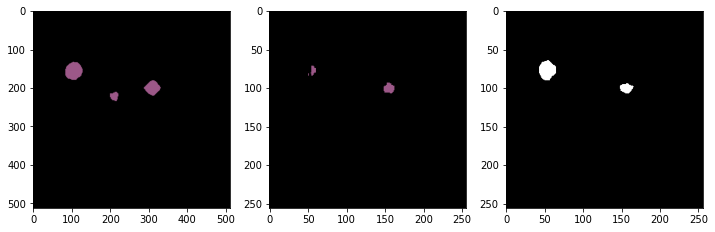

In [5]:
print(fusion_model.weights.weight / torch.sum(fusion_model.weights.weight))
show_model_seg(fusion_model.cpu(), training_dataset, 45)

## Salvam segementarile din sistemul de fuziune

In [6]:
fusion_model.eval()
iter = 0
with torch.no_grad():
    imagesize = 0
    for X, Y in tqdm(training_dataloader):
        imagesize = torch.numel(Y)
        pred = fusion_model(X.to(device))
        final_func = nn.Sigmoid()
        pred = final_func(pred)
        pred = torch.nn.functional.interpolate(pred, size=256, mode="bilinear", align_corners=False).squeeze()
        pred = torch.round(pred)
        for i in range(pred.size(dim = 0)):
            slc = pred[i, :, :]
            slc = slc.cpu().numpy()
            slc.astype(np.int8).tofile('G:/MachineLearning/lesion-database/validation/Fusion/output' + ("-%04d.ct" % iter))
            iter = iter + 1

100%|██████████| 95/95 [00:09<00:00,  9.79it/s]
